In [97]:
%matplotlib inline
import numpy as np

# for plotting images + graphs
import matplotlib.pyplot as plt

# OpenCV for reading image files from disk + converting color formats
import cv2

# tqdm makes progress bar
from tqdm import tqdm

import os

import pandas as pd

import sys
sys.path.append("..")  

from utils.preprocessing import (
    compute_fft_blur_score,
    check_blurry_fft,
    filter_sharp_images,
    
)

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
healthy_raw = '../data/raw/healthy_eye'
infected_raw = '../data/raw/infected_eye'

In [100]:
# lists all the files in each folder
# slices the first five

# (optional) print first 5 raw filenames
healthy_imgs = os.listdir(healthy_raw)[:5]
infected_imgs = os.listdir(infected_raw)[:5]

print("Healthy files: ", healthy_imgs)
print("Infected files: ", infected_imgs)


Healthy files:  ['63.jpg', '823.jpg', '189.jpg', '77.jpg', '638.jpg']
Infected files:  ['63.jpg', '189.jpg', '77.jpg', '162.jpg', '176.jpg']


In [101]:
# filtered output (only sharp images)
filtered_healthy  = '../data/filtered/healthy_eye'
filtered_infected = '../data/filtered/infected_eye'
os.makedirs(filtered_healthy,  exist_ok=True)
os.makedirs(filtered_infected, exist_ok=True)

In [102]:
def load_image_convert(img_path):

    # loads image
    img = cv2.imread(img_path)

    # opencv reads in bgr, but matplotlib needs rgb
    # so converts colors
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

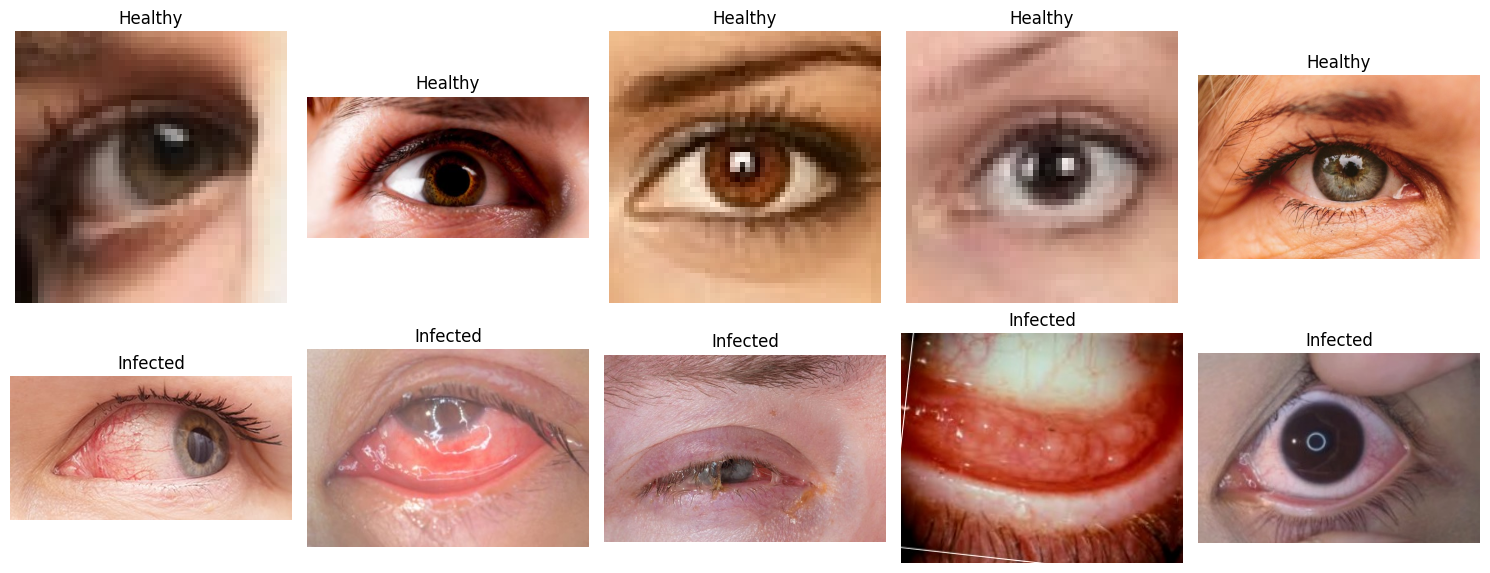

In [103]:
# makes a 2 row, 5 col grid of plots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, img_file in enumerate(healthy_imgs):
    img_rgb = load_image_convert(os.path.join(healthy_raw, img_file))

    # shows the image
    axs[0, i].imshow(img_rgb)

    # makes title
    axs[0, i].set_title("Healthy")

    # no x/y ticks
    axs[0, i].axis('off')

for i, img_file in enumerate(infected_imgs):
    img_rgb = load_image_convert(os.path.join(infected_raw, img_file))

    # shows the image
    axs[1, i].imshow(img_rgb)

    # makes title
    axs[1, i].set_title("Infected")

    # no x/y ticks
    axs[1, i].axis('off')

# remove overlap bw graphs
plt.tight_layout()

plt.show()

In [104]:
# loads a sample of each
healthy_sample = cv2.imread(os.path.join(healthy_raw, healthy_imgs[0]))
infected_sample = cv2.imread(os.path.join(infected_raw, infected_imgs[0]))

In [105]:
# inspect their shapes
print("Healthy image sample shape:", healthy_sample.shape)
print("Infected image sample shape:", infected_sample.shape)

Healthy image sample shape: (47, 47, 3)
Infected image sample shape: (166, 325, 3)


In [106]:
import os

def clean_folder(folder_path):
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            os.remove(file_path)

# Toggle cleanup ON or OFF
RUN_CLEANUP = False  # ← change to True only when needed

if RUN_CLEANUP:
    clean_folder('../data/filtered/healthy_eye')
    clean_folder('../data/filtered/infected_eye')
    print("Old filtered images deleted.")
else:
    print("Filtered folder untouched; ready for fresh preprocessing.")

Filtered folder untouched; ready for fresh preprocessing.


In [107]:
# call and collect skipped files
# skipped_healthy = clean_resize_imgs(healthy_path, processed_healthy_path, "Healthy")
# skipped_infected = clean_resize_imgs(infected_path, processed_infected_path, "Infected")

# resize *all* raw images into your “processed” folders
#resize_and_save_all(healthy_path, processed_healthy_path, size=224)
# resize_and_save_all(infected_path, processed_infected_path, size=224)


# Optional: check padding visually on first 3 processed healthy images
'''sample_imgs = os.listdir(processed_healthy_path)[:3]

for fname in sample_imgs:
    img = cv2.imread(os.path.join(processed_healthy_path, fname))
    print(f"{fname} shape: {img.shape}")  # confirm size is 224x224

    # Show with clear padding detection (vmin/vmax avoid matplotlib scaling tricks)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)
    plt.title(f"Padded Healthy Image: {fname}")
    plt.axis('off')
    plt.show()

# merge both logs
# skipped_files = skipped_healthy + skipped_infected
'''

'sample_imgs = os.listdir(processed_healthy_path)[:3]\n\nfor fname in sample_imgs:\n    img = cv2.imread(os.path.join(processed_healthy_path, fname))\n    print(f"{fname} shape: {img.shape}")  # confirm size is 224x224\n\n    # Show with clear padding detection (vmin/vmax avoid matplotlib scaling tricks)\n    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=0, vmax=255)\n    plt.title(f"Padded Healthy Image: {fname}")\n    plt.axis(\'off\')\n    plt.show()\n\n# merge both logs\n# skipped_files = skipped_healthy + skipped_infected\n'

In [108]:
# %%
sharp_scores_h = []
for f in os.listdir(healthy_raw):
    img = cv2.imread(os.path.join(healthy_raw, f))
    if img is None: 
        continue
    sharp_scores_h.append(compute_fft_blur_score(img))

sharp_scores_i = []
for f in os.listdir(infected_raw):
    img = cv2.imread(os.path.join(infected_raw, f))
    if img is None: 
        continue
    sharp_scores_i.append(compute_fft_blur_score(img))

dynamic_thresh_h = np.percentile(sharp_scores_h, 5)
dynamic_thresh_i = np.percentile(sharp_scores_i, 5)
print("Healthy threshold:", dynamic_thresh_h)
print("Infected threshold:", dynamic_thresh_i)

Healthy threshold: 4.548369987573383
Infected threshold: -6.020657147818755


In [109]:
# %%
sharp_healthy = filter_sharp_images(
    input_path        = healthy_raw,
    output_path       = filtered_healthy,
    dynamic_threshold = dynamic_thresh_h,
    label             = "Healthy"
)
sharp_infected = filter_sharp_images(
    input_path        = infected_raw,
    output_path       = filtered_infected,
    dynamic_threshold = dynamic_thresh_i,
    label             = "Infected"
)

Filtering Infected: 100%|██████████| 534/534 [00:05<00:00, 97.64it/s] 


In [110]:
# save skipped file info in csv
'''if skipped_files:
    os.makedirs('../data/log', exist_ok=True)
    df_skipped = pd.DataFrame(skipped_files, columns=['filename', 'reason'])
    df_skipped.to_csv('../data/log/skipped_images_log.csv', index=False)
    print(f"Logged {len(skipped_files)} skipped files to ../data/log/skipped_images_log.csv")
else:
    print("No files were skipped.")
    '''

'if skipped_files:\n    os.makedirs(\'../data/log\', exist_ok=True)\n    df_skipped = pd.DataFrame(skipped_files, columns=[\'filename\', \'reason\'])\n    df_skipped.to_csv(\'../data/log/skipped_images_log.csv\', index=False)\n    print(f"Logged {len(skipped_files)} skipped files to ../data/log/skipped_images_log.csv")\nelse:\n    print("No files were skipped.")\n    '

In [111]:
num_filtered_healthy   = len(os.listdir(filtered_healthy))
num_filtered_infected  = len(os.listdir(filtered_infected))

print(f"Filtered healthy images: {num_filtered_healthy}")
print(f"Filtered infected images: {num_filtered_infected}")


Filtered healthy images: 788
Filtered infected images: 507


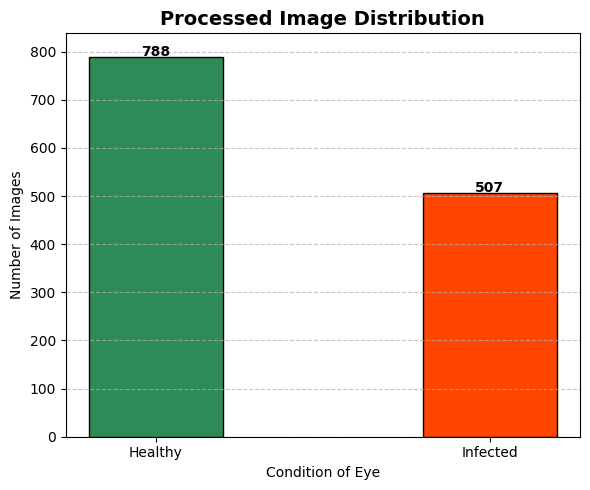

In [112]:

x = np.array(["Healthy", "Infected"])
y = np.array([num_filtered_healthy, num_filtered_infected])

plt.figure(figsize=(6, 5))
plt.bar(x, y, color=['seagreen', 'orangered'], width=0.4, edgecolor='black')

# label values
for i, val in enumerate(y):
    plt.text(i, val + 2, str(val), ha='center', fontweight='bold')

plt.ylim(0, max(y)+50)
plt.xlabel("Condition of Eye")
plt.ylabel("Number of Images")
plt.title("Processed Image Distribution", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

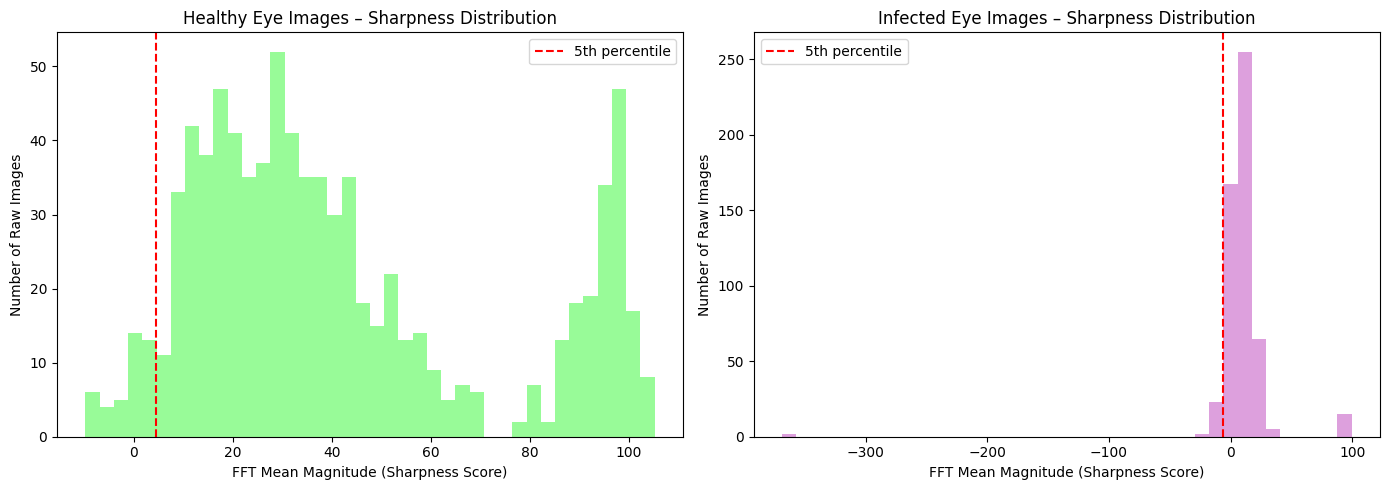

In [113]:

# shows the distribution of FFT-based sharpness scores
# for healthy and infected eyes  
# marks the threshold
# that separates the blurriest 5% from the rest
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Healthy-eye sharpness distribution
axes[0].hist(sharp_scores_h, bins=40, color='palegreen')
axes[0].axvline(x=dynamic_thresh_h, color='red', linestyle='--', label='5th percentile')
axes[0].set_xlabel("FFT Mean Magnitude (Sharpness Score)")
axes[0].set_ylabel("Number of Raw Images")
axes[0].set_title("Healthy Eye Images – Sharpness Distribution")
axes[0].legend()

# Infected-eye sharpness distribution
axes[1].hist(sharp_scores_i, bins=40, color='plum')
axes[1].axvline(x=dynamic_thresh_i, color='red', linestyle='--', label='5th percentile')
axes[1].set_xlabel("FFT Mean Magnitude (Sharpness Score)")
axes[1].set_ylabel("Number of Raw Images")
axes[1].set_title("Infected Eye Images – Sharpness Distribution")
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/plots/fft_sharpness_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [114]:
# MOVE flagged images BACK into processed
# import shutil

# for file in os.listdir(flagged_healthy_path):
#     shutil.move(os.path.join(flagged_healthy_path, file), os.path.join(processed_healthy_path, file))

# for file in os.listdir(flagged_infected_path):
#     shutil.move(os.path.join(flagged_infected_path, file), os.path.join(processed_infected_path, file))

In [115]:
# OPTIONAL: Clean flagged folders completely
# for file in os.listdir(flagged_healthy_path):
#    os.remove(os.path.join(flagged_healthy_path, file))

# for file in os.listdir(flagged_infected_path):
#     os.remove(os.path.join(flagged_infected_path, file))

In [116]:
# sharp_healthy and sharp_infected are lists of (filename, score)
df_h = pd.DataFrame(sharp_healthy, columns=['filename','sharpness_score'])
df_h['label'] = 'healthy'
df_i = pd.DataFrame(sharp_infected, columns=['filename','sharpness_score'])
df_i['label'] = 'infected'

df = pd.concat([df_h, df_i], ignore_index=True)
os.makedirs('../logs', exist_ok=True)
df.to_csv('../logs/filtered_images_log.csv', index=False)

print(f"Logged {len(df)} filtered images to ../logs/filtered_images_log.csv")

Logged 1295 filtered images to ../logs/filtered_images_log.csv


In [117]:

# build lists of the images that failed the sharpness test
blurry_h = []
for fname in os.listdir(healthy_raw):
    img = cv2.imread(os.path.join(healthy_raw, fname))
    if img is None:
        continue
    is_blur, score = check_blurry_fft(img, dynamic_thresh_h)
    if is_blur:
        blurry_h.append((fname, score))

blurry_i = []
for fname in os.listdir(infected_raw):
    img = cv2.imread(os.path.join(infected_raw, fname))
    if img is None:
        continue
    is_blur, score = check_blurry_fft(img, dynamic_thresh_i)
    if is_blur:
        blurry_i.append((fname, score))

# turn into a DataFrame and save
df_h = pd.DataFrame(blurry_h, columns=['filename','sharpness_score'])
df_h['label'] = 'healthy'
df_h['threshold_used'] = dynamic_thresh_h

df_i = pd.DataFrame(blurry_i, columns=['filename','sharpness_score'])
df_i['label'] = 'infected'
df_i['threshold_used'] = dynamic_thresh_i

df_blur = pd.concat([df_h, df_i], ignore_index=True)
os.makedirs('../logs', exist_ok=True)
df_blur.to_csv('../logs/blurry_images_log.csv', index=False)

print(f"Logged {len(df_blur)} blurry images to ../logs/blurry_images_log.csv")

Logged 69 blurry images to ../logs/blurry_images_log.csv
